Comparing merge-tests between 3.6 revision r5890 and r5628. 

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [4]:
#load in the datas. Trying something new with dict objects...

#first run (r5628)
r1 = 'r5628';
runname1 = '/ocean/nsoontie/MEOPAR/SalishSea/results/merge-apr2016/base/'
print (runname1)

#second run (r5890)
r2 = 'r5890'
runname2 = ('/ocean/sallen/allen/research/MEOPAR/myResults/merge-apr2016/r5890/')
print (runname2)

runs = {r1: runname1, r2: runname2}


/ocean/nsoontie/MEOPAR/SalishSea/results/merge-apr2016/base/
/ocean/sallen/allen/research/MEOPAR/myResults/merge-apr2016/r5890/


In [12]:
fUs={}; fVs={}; fTs={}
for key, path in runs.items():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_T.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_T.nc','r');

Show info about the files

In [14]:
for key in runs:
    print (key)
    nc_tools.show_dataset_attrs(fUs[key])

r5890
file format: NETCDF4
name: SalishSea_1h_20160102_20160104
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-May-06 15:55:29 PDT
history: Fri May  6 16:50:50 2016: ncks -4 -L4 -O SalishSea_1h_20160102_20160104_grid_U.nc SalishSea_1h_20160102_20160104_grid_U.nc
NCO: "4.5.2"
r5628
file format: NETCDF4
name: SalishSea_1h_20160102_20160104
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-Apr-21 09:19:13 PDT
history: Thu Apr 21 10:23:21 2016: ncks -4 -L4 -O SalishSea_1h_20160102_20160104_grid_U.nc SalishSea_1h_20160102_20160104_grid_U.nc
NCO: "4.5.2"


In [15]:
for key in runs:
    print (key)
    nc_tools.show_variable_attrs(fUs[key])

r5890
<class 'netCDF4._netCDF4.Variable'>
float32 depthu(depthu)
    long_name: Vertical U levels
    units: m
    axis: Z
    positive: down
    bounds: depthu_bounds
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 depthu_bounds(depthu, axis_nbounds)
unlimited dimensions: 
current shape = (40, 2)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    nav_model: grid_U
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    nav_model: grid_U
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.969209968386869e+36 use

Different sizes because initial is 48 hours. 

In [18]:
#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig[r1] = datetime.datetime.strptime(
                    tim_count[r1].time_origin.title(), '%Y-%m-%d %H:%M:%S')
t_orig[r2] = datetime.datetime.strptime(
                tim_count[r2].time_origin.title(), '%Y-%m-%d %H:%M:%S')


### Comparison plots

Quick look at surface fields near the start adn end of first day

In [33]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
        print (var_name, 'max', np.max(var[r1][t,:,:]-var[r2][t,:,:]), 
               'min', np.min(var[r1][t,:,:]-var[r2][t,:,:]))
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
        print (var_name, 'max', np.max(var[r1][t, depthlevel, :, :]-var[r2][t, depthlevel, :, :]), 
               'min', np.min(var[r1][t, depthlevel, :, :] - var[r2][t, depthlevel, :, :]))
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0
U [m/s] max 0.0 min 0.0
V [m/s] max 0.0 min 0.0
SSH [m] max 0.0 min 0.0
Sal [g/kg] max 0.0 min 0.0
Temp [deg C] max 0.0 min 0.0


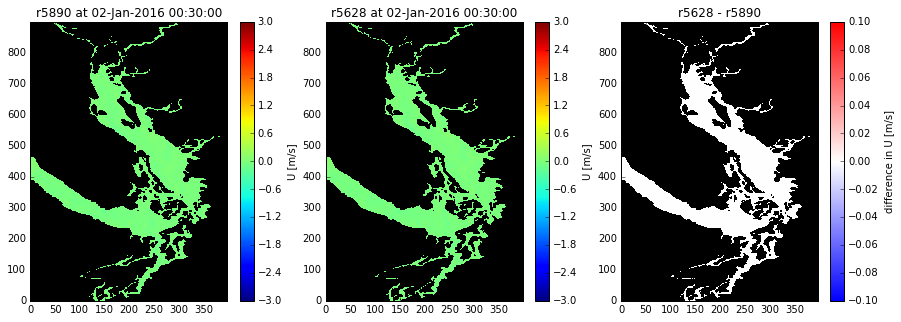

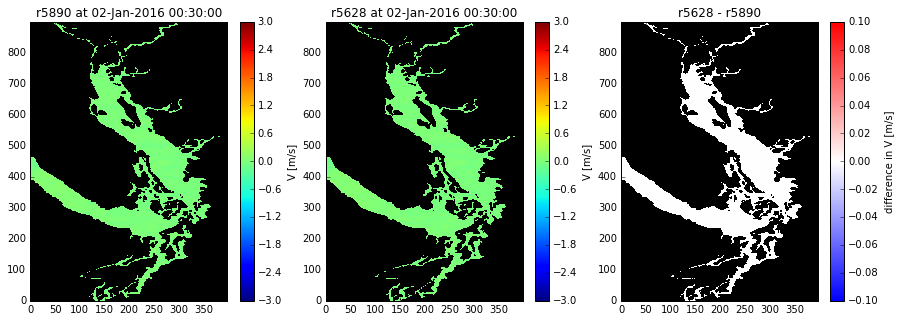

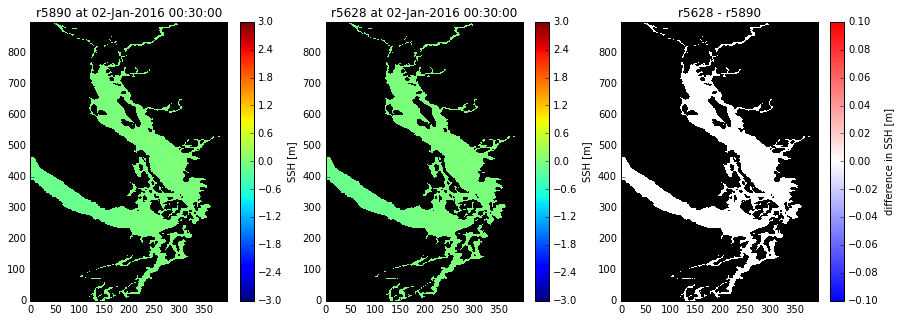

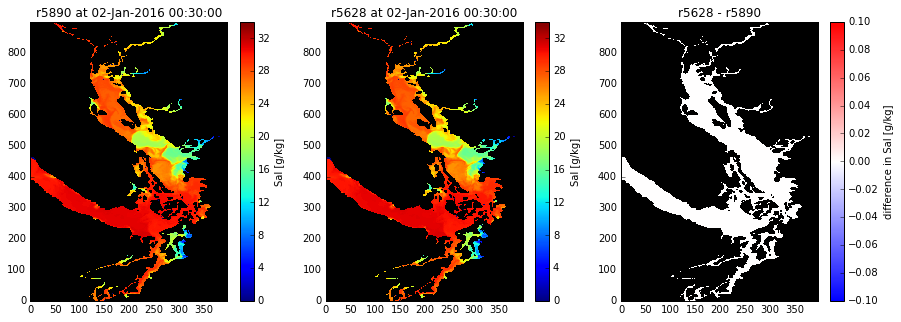

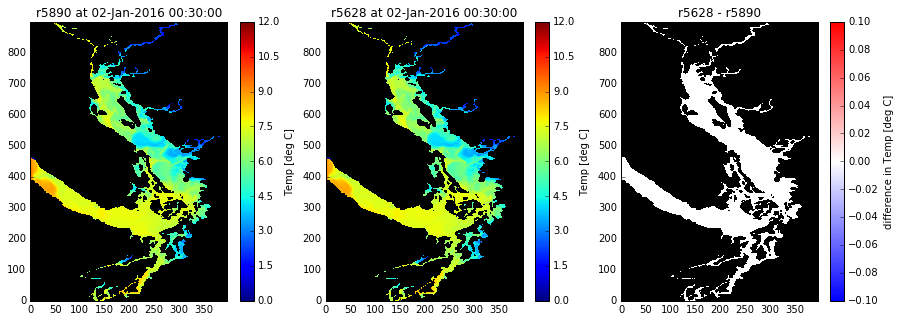

In [29]:
t=0
depthlevel=0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

No differences.

Time = 63, depth level = 0
U [m/s] max 0.0 min 0.0
V [m/s] max 0.0 min 0.0
SSH [m] max 0.0 min 0.0
Sal [g/kg] max 0.0 min 0.0
Temp [deg C] max 0.0 min 0.0


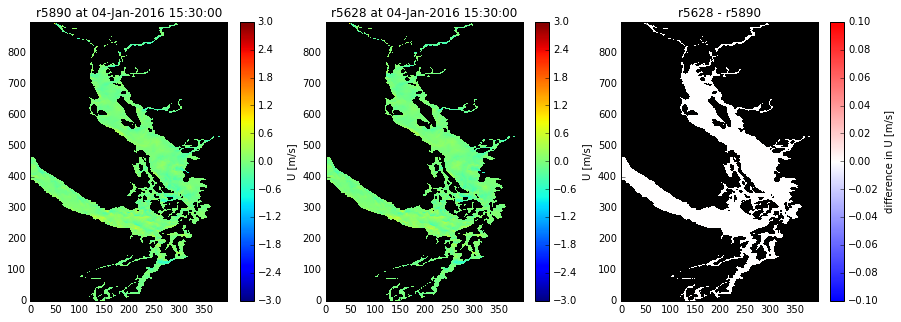

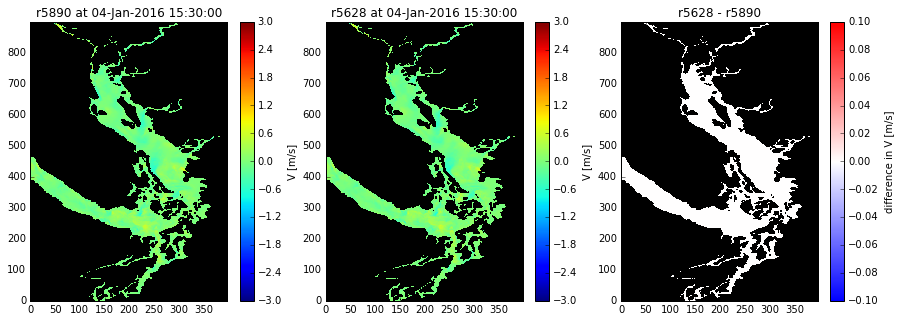

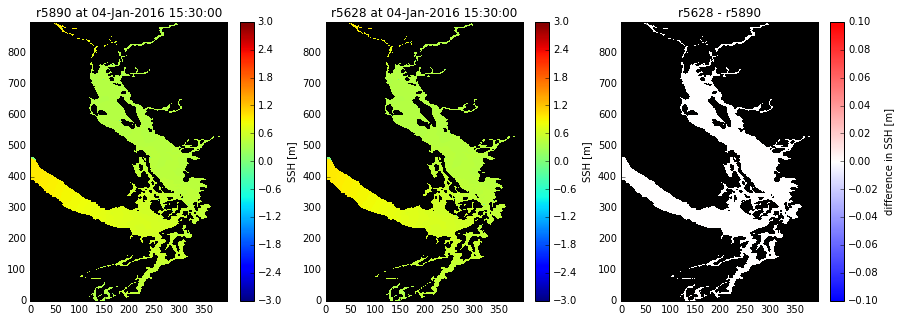

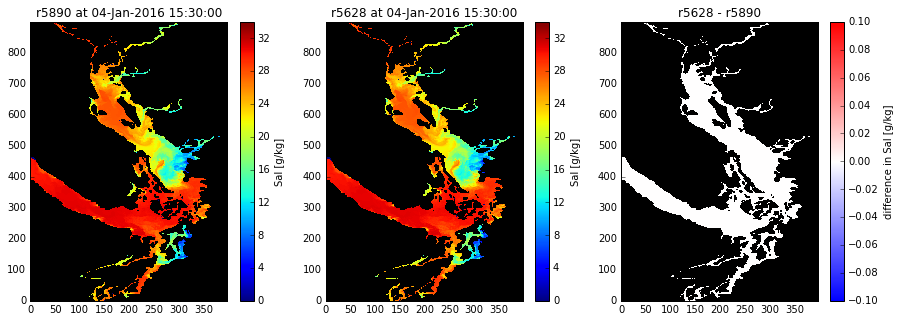

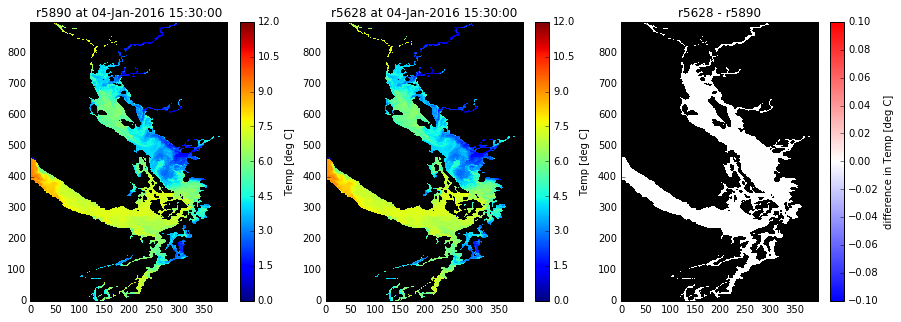

In [34]:
t=63
depthlevel=0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

* No differences.

# Profiles

In [35]:
def compare_profile(var,var_name, i,j,t,zmin=0,zmax=400,vmin=0,vmax=34):
    """Function to compare a variable over depth at point i,j and time t.
    Plots each sim on the same axis and then their difference over depth"""

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    for key in runs:
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        ax.plot(var[key][t,:,j,i],Ds[key], '-o',label=key)
    ax.set_title(out.strftime('%d-%b-%Y %H:%M:%S'))
    ax.set_xlabel(var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.legend(loc=0)
    ax=axs[1]
    #difference    
    diff = var[r1][t,:,j,i]-var[r2][t,:,j,i]
    ax.plot(diff,Ds[key], '-ro')
    ax.set_title('Difference: ' +r1+' - ' +r2)
    ax.set_xlabel('Difference in ' + var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])

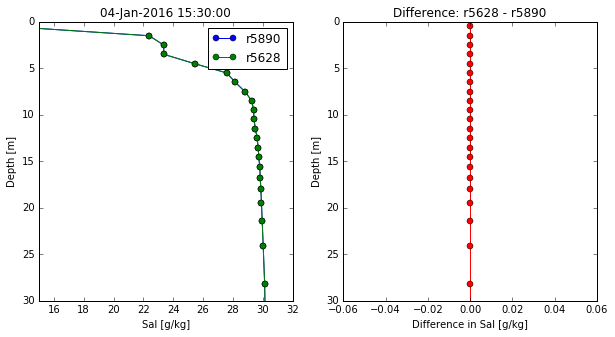

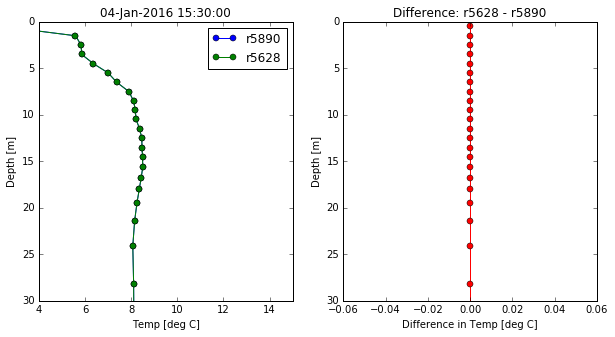

In [36]:
tp = 63
ip = 300
jp = 450
zmax= 30
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=4,vmax=15)

* Central SoG

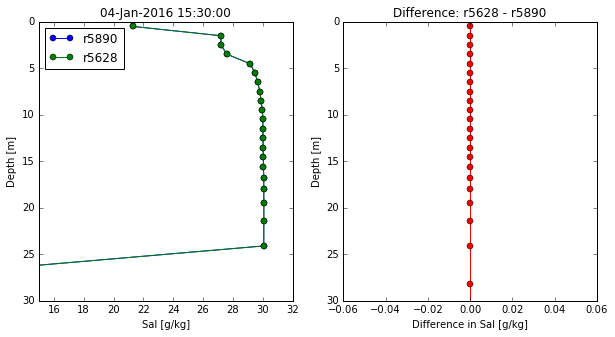

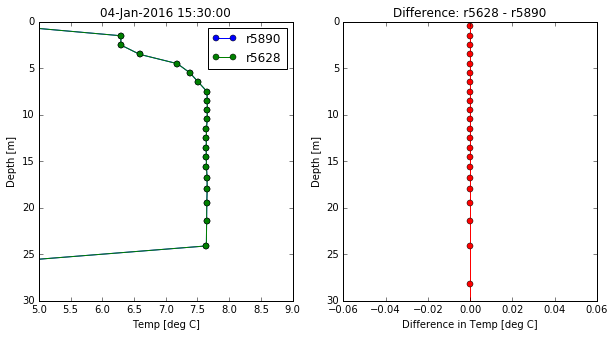

In [37]:
tp = 63
ip = 300
jp = 400
zmax=30
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=9)


* Closer to Boundary Pass

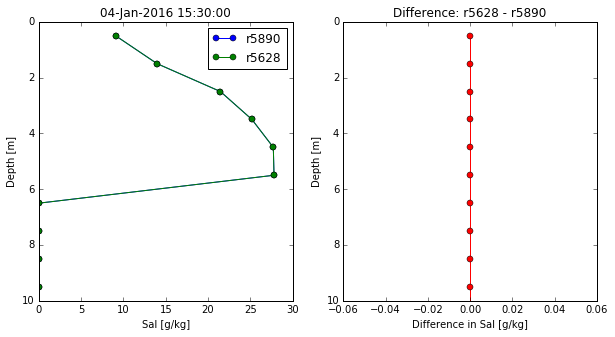

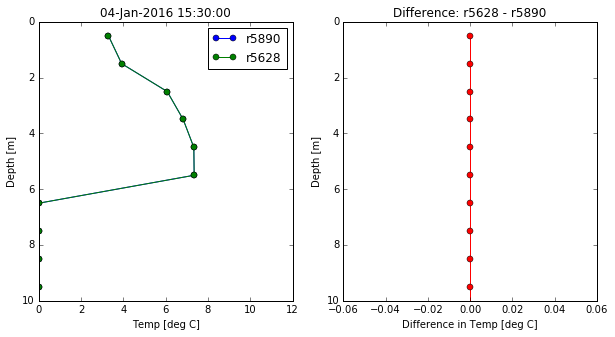

In [39]:
tp = 63
ip = 310
jp = 430
zmax=10
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=30)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=12)

* Right in plume
* No difference

## Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [43]:
def summarize_differences(var, var_name, imin=0, imax=396, jmin=0, jmax=896, ts=24):
    diff = var[r1][0:ts,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print (var_name)
    print ('min diff: {0:.3}, index {1}'.format(diff.min(),inds_min))
    print ('max diff: {0:.3}, index {1}'.format(diff.max(),inds_max))
    print ('mean diff {0:.3}'.format(diff.mean()))

In [44]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key], key, ts=64)

V [m/s]
min diff: 0.0, index (0, 0, 0, 0)
max diff: 0.0, index (0, 0, 0, 0)
mean diff 0.0
U [m/s]
min diff: 0.0, index (0, 0, 0, 0)
max diff: 0.0, index (0, 0, 0, 0)
mean diff 0.0
Sal [psu]
min diff: 0.0, index (0, 0, 0, 0)
max diff: 0.0, index (0, 0, 0, 0)
mean diff 0.0
SSH [m]
min diff: 0.0, index (0, 0, 0)
max diff: 0.0, index (0, 0, 0)
mean diff 0.0
Temp [deg C]
min diff: 0.0, index (0, 0, 0, 0)
max diff: 0.0, index (0, 0, 0, 0)
mean diff 0.0


* Diffs Clean

### Boundary conditions on SSH

How do the ssh/u/v near the boundaries compare?

In [45]:
sshs={}
us={}
vs={}
i=1
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
        

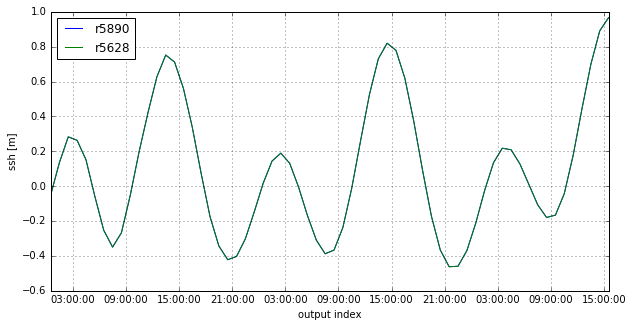

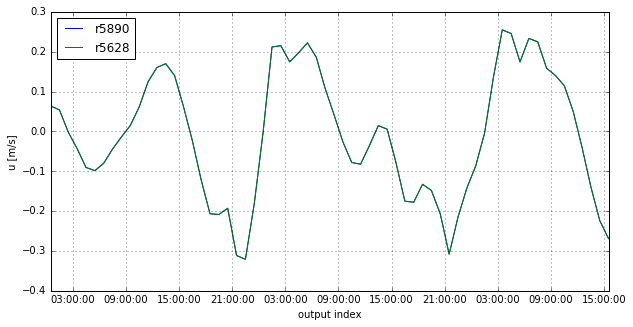

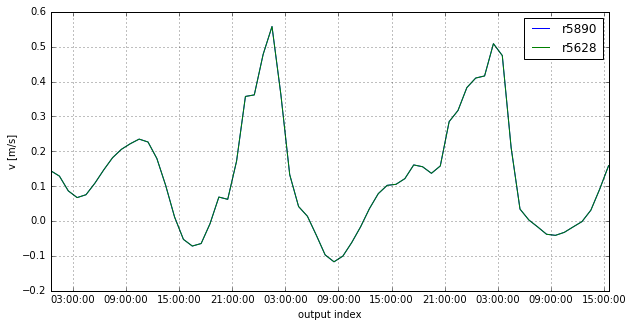

In [46]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()


Next to boundary

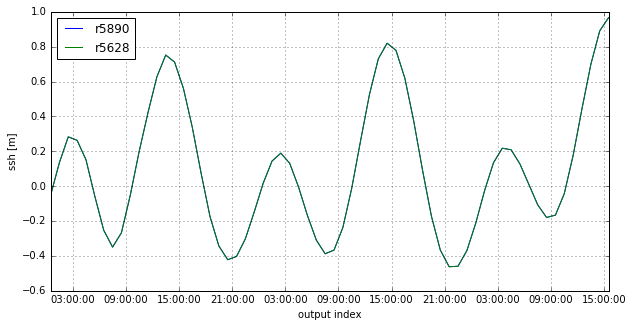

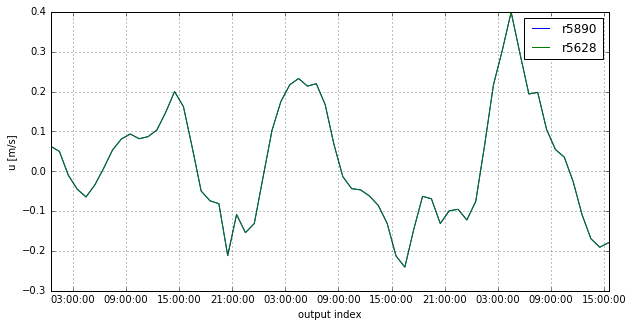

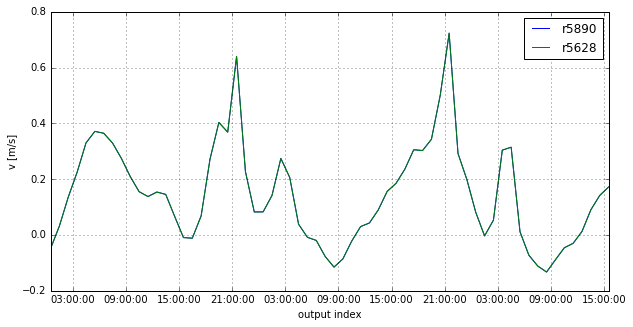

In [47]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

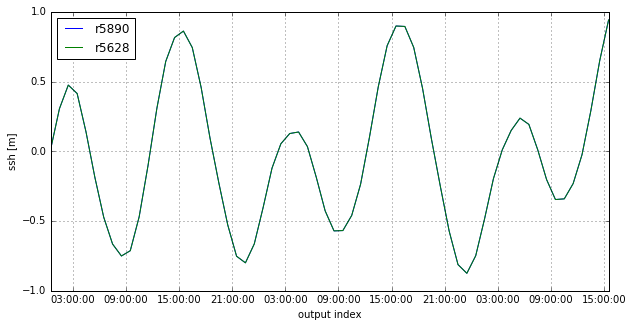

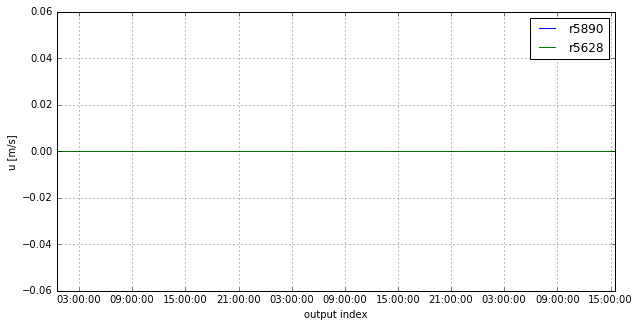

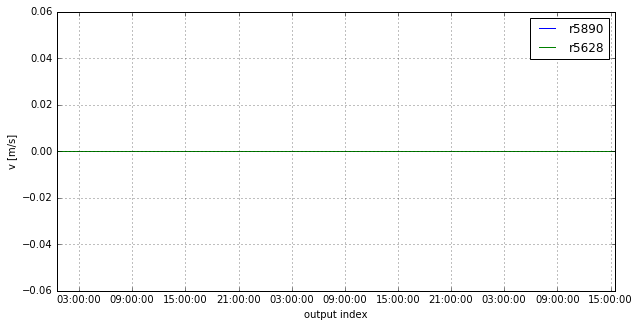

In [48]:
sshs={}
us={}
vs={}
i=50
j=896
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

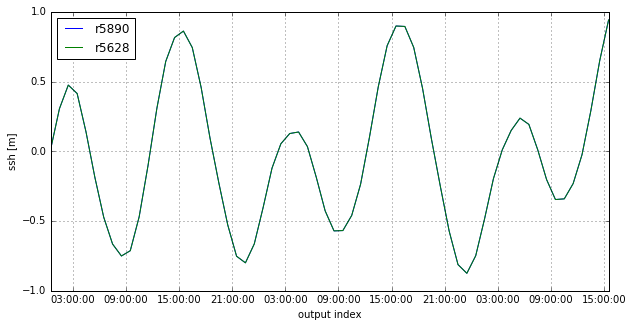

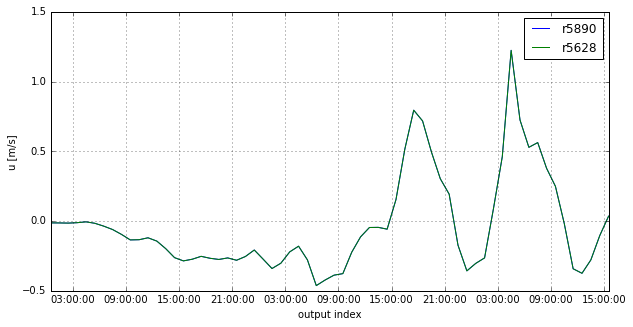

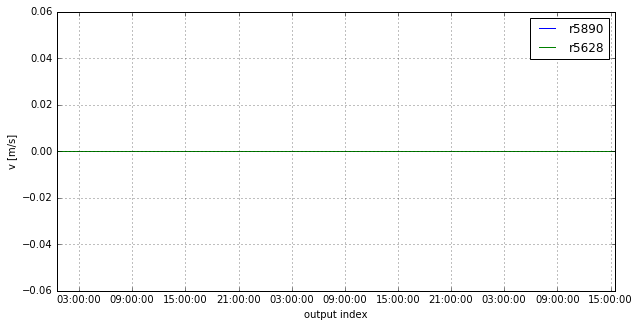

In [49]:
sshs={}
us={}
vs={}
i=50
j=895
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Phases align!

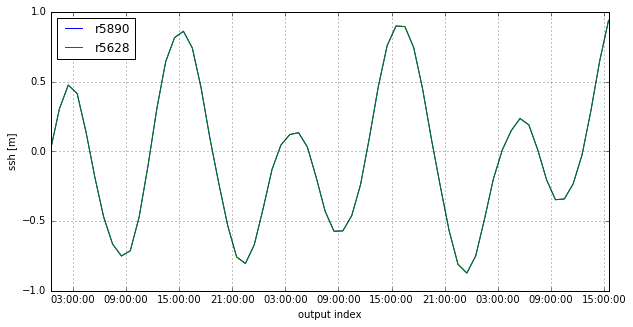

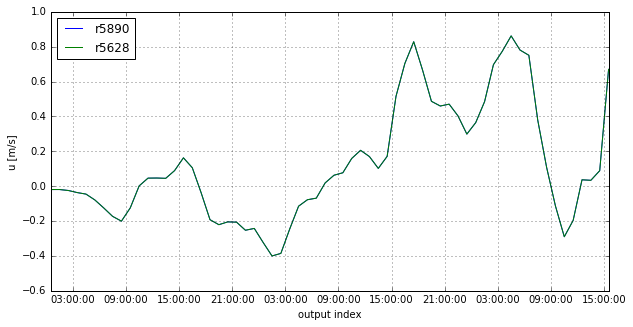

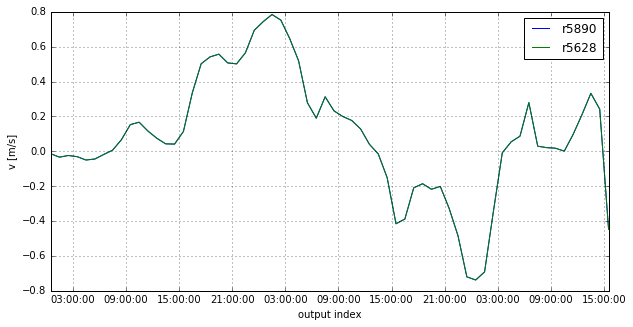

In [50]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

# Closer look at currents at SJdF boundary

Compare fields over depth and along the JdF boundary

In [51]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin,vmax=diffmax)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


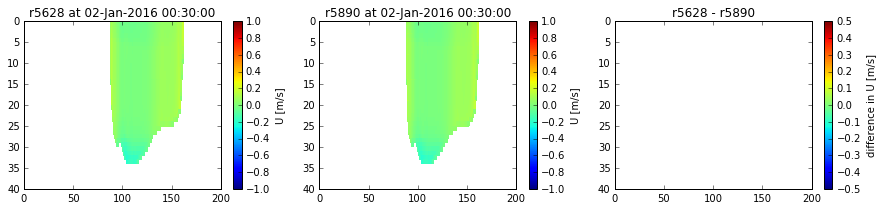

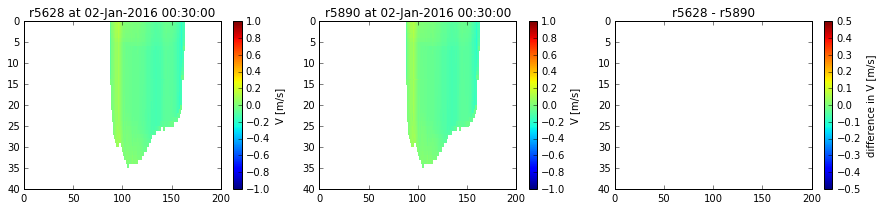

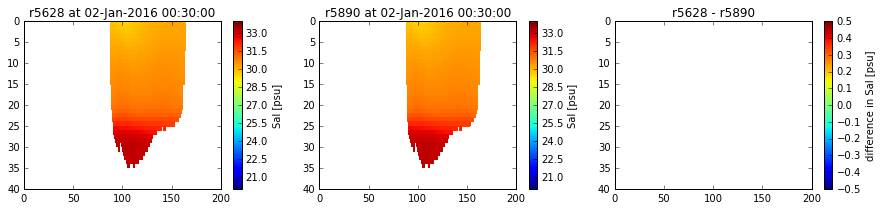

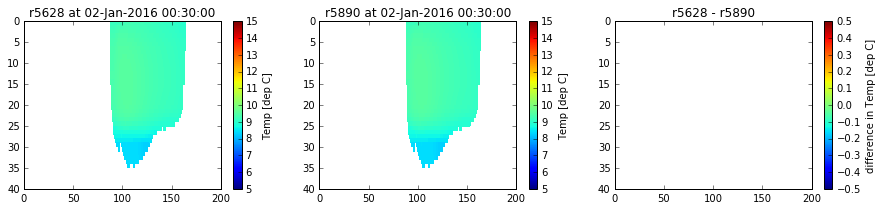

In [53]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

Max difference time (isn't one)

Mouth of JdF at t = 5


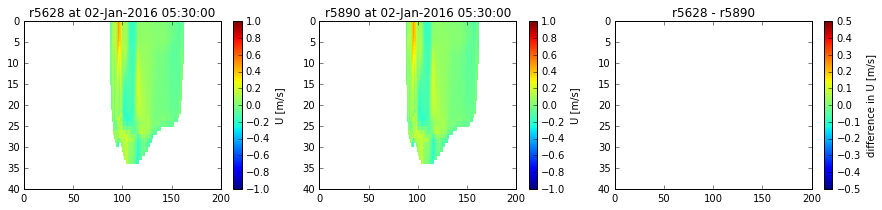

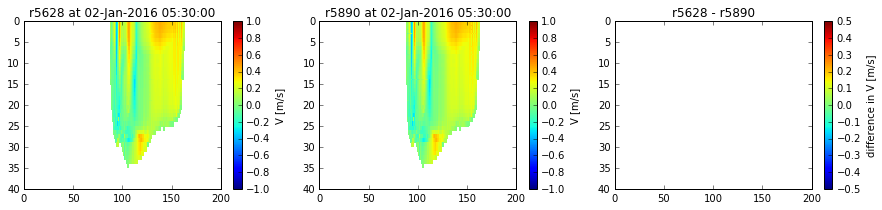

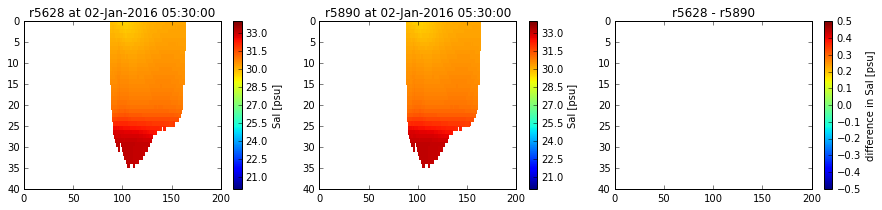

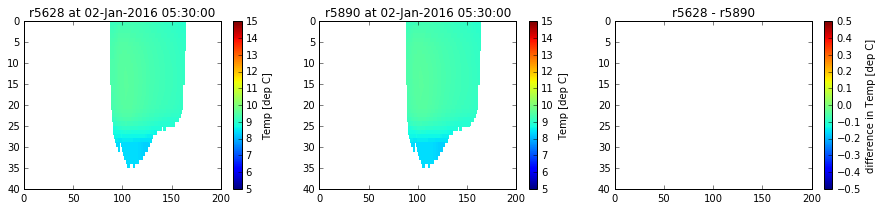

In [55]:
t=5
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

Last time

In [ ]:
t=63
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

## Total == No Change